# <XGBoost를 이용한 게임 판매량 예측 모델>

- 자료 링크: https://www.kaggle.com/datasets/gregorut/videogamesales
- 이 프로젝트에서 사용한 자료는 **vgsales.csv**라는 비디오 게임 판매 데이터셋입니다. 이 데이터셋은 전 세계에서 출시된 비디오 게임들의 다양한 판매 정보와 그에 관련된 여러 특성들을 포함하고 있습니다. 데이터는 총 11의 컬럼을 가지고 있으며, 각 게임에 대한 판매량 정보, 플랫폼, 장르, 출판사 등 여러 정보를 제공합니다.

- 특징(Features):
이 데이터셋에서 모델에 입력되는 특징들은 비디오 게임의 여러 속성입니다. 그중 예측 모델이 사용될 특징은 다음과 같습니다:

    - Platform: 게임이 출시된 플랫폼 (예: PlayStation, Xbox 등)
    - Year: 게임이 출시된 연도
    - Genre: 게임의 장르 (예: Action, Adventure, RPG 등)
    - Publisher: 게임의 출판사 (예: EA, Nintendo 등)
 
    - NA_Sales, EU_Sales, JP_Sales, Other_Sales는 타겟 변수인 Global_Sales와 높은 상관관계를 가지며, 실제로 이 값들의 합으로 Global_Sales가 계산됩니다. 따라서, 이 변수를 포함하면 모델이 단순히 합계를 계산하는 데 초점이 맞춰져 학습의 의미가 약화될 수 있으므로 제외합니다.
    - Name은 특정 게임의 이름으로, 정성적인 정보일 뿐 타겟 변수인 판매량과 직접적인 상관관계가 없다고 판단되므로 제외합니다.
 
    - 자료의 개수: 16598개


- 라벨(Label) 또는 타겟(Target):
타겟(라벨) 변수는 **Global_Sales**입니다. 이 변수는 각 게임의 전 세계 판매량을 나타내며, 예측하려는 목표입니다. 'Global_Sales' 값은 모델이 학습을 통해 예측해야 할 값으로, 회귀 문제의 타겟 변수로 설정됩니다.

### XGBoost를 사용하는 이유
1. 성능 최적화
XGBoost는 Gradient Boosting 알고리즘의 확장으로, 빠르고 효율적이며 고성능의 모델을 제공합니다.
비선형 관계를 잘 처리하고, 적은 데이터로도 높은 정확도를 달성할 수 있습니다.
2. 정교한 특성 처리
XGBoost는 결측값 자동 처리와 특성 중요도 평가 기능을 내장하고 있어, 데이터 전처리와 모델 해석에 유리합니다.
3. 과적합 방지
정규화 파라미터(예: learning_rate, max_depth, gamma)를 통해 **과적합(overfitting)**을 효과적으로 제어할 수 있습니다.
4. 빠른 학습 속도
병렬 처리와 하드웨어 최적화를 통해, 대규모 데이터에서도 빠른 학습 속도를 제공합니다.
5. 적합한 문제 유형
이 데이터셋의 목표는 Global_Sales를 예측하는 회귀 문제입니다. XGBoost는 회귀 문제에 적합한 **객체 함수(reg:squarederror)**와 평가 지표를 제공하므로, 문제에 잘 맞는 알고리즘입니다.

# 1. 라이브러리 불러오기

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Image

# 2. 데이터 로드

In [6]:
# 데이터 로드
url = "C:/Users/user/Downloads/vgsales.csv"
data = pd.read_csv(url)

In [7]:
data = data.drop(columns=["Unnamed: 0"], errors="ignore") #특징이 아닌 첫번째 데이터 삭제
data.head() #5번째 행까지 데이터 보기

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [8]:
print("\n데이터 요약 정보:\n")
print(data.info())  # 데이터 타입 확인


데이터 요약 정보:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None


In [9]:
print("\n기술 통계 정보:\n")
print(data.describe())  # 수치형 변수 통계


기술 통계 정보:

               Rank          Year      NA_Sales      EU_Sales      JP_Sales  \
count  16598.000000  16327.000000  16598.000000  16598.000000  16598.000000   
mean    8300.605254   2006.406443      0.264667      0.146652      0.077782   
std     4791.853933      5.828981      0.816683      0.505351      0.309291   
min        1.000000   1980.000000      0.000000      0.000000      0.000000   
25%     4151.250000   2003.000000      0.000000      0.000000      0.000000   
50%     8300.500000   2007.000000      0.080000      0.020000      0.000000   
75%    12449.750000   2010.000000      0.240000      0.110000      0.040000   
max    16600.000000   2020.000000     41.490000     29.020000     10.220000   

        Other_Sales  Global_Sales  
count  16598.000000  16598.000000  
mean       0.048063      0.537441  
std        0.188588      1.555028  
min        0.000000      0.010000  
25%        0.000000      0.060000  
50%        0.010000      0.170000  
75%        0.040000     

# 3. 데이터 전처리

In [11]:
#결측치 확인
print(data.isnull().sum())

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


- Year는 수치형 변수이므로, 결측치를 중앙값으로 대체.

In [13]:
data['Year'] = data['Year'].fillna(data['Year'].median())

- publisher는 범주형 변수이므로, 결측치를 최빈값으로 대체.

In [15]:
data['Publisher'] = data['Publisher'].fillna(data['Publisher'].mode()[0])

- 중복된 행 확인

In [17]:
duplicates = data.duplicated()
print(f"중복된 데이터 개수: {duplicates.sum()}")

중복된 데이터 개수: 0


- 불필요한 열 제거

In [19]:
data.drop(['Name','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'], axis=1, inplace=True)

- 범주형 데이터 원-핫 인코딩

In [21]:
categorical_cols = ['Platform', 'Genre', 'Publisher']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [22]:
# 예: Global_Sales의 이상치 확인
q1 = data['Global_Sales'].quantile(0.25)
q3 = data['Global_Sales'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data[(data['Global_Sales'] < lower_bound) | (data['Global_Sales'] > upper_bound)]
print(f"이상치 개수: {len(outliers)}")

이상치 개수: 1893


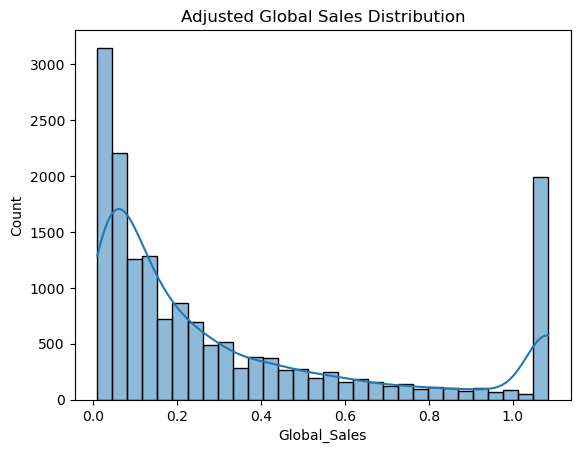

In [23]:
# 이상치 값을 경계값으로 조정 (윈저라이징)
data['Global_Sales'] = np.where(
    data['Global_Sales'] < lower_bound, lower_bound,
    np.where(data['Global_Sales'] > upper_bound, upper_bound, data['Global_Sales'])
)

# 조정 후 분포 확인
import seaborn as sns
sns.histplot(data['Global_Sales'], kde=True, bins=30)
plt.title('Adjusted Global Sales Distribution')
plt.show()

In [24]:
data.head()

,Rank,Year,Global_Sales,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
0,1,2006.0,1.085,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,1985.0,1.085,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,2008.0,1.085,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,2009.0,1.085,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,1996.0,1.085,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


최종 변수 - Year, NA_Sales, EU_Sales, JP_Sales, Other_Sales, 원-핫 인코딩 된 Platform, Genre, Publisher

# 4. 훈련 데이터와 테스트 데이터 분할

In [27]:
# 독립 변수 (X)와 종속 변수 (y) 분리.  여러가지 판매량 열이 존재하므로 하나를 선택해야 합니다.
X = data.drop(['Global_Sales'], axis=1)
y = data['Global_Sales'] # 예시: Global_Sales 를 예측 목표로 설정

In [28]:
# 데이터 분할 (훈련 데이터: 80%, 테스트 데이터: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print("훈련 데이터 크기:", X_train.shape)
print("테스트 데이터 크기:", X_test.shape)

훈련 데이터 크기: (13278, 620)
테스트 데이터 크기: (3320, 620)


# 5. 모델 학습

In [31]:
# 모델 초기화
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42
)

In [32]:
# 모델 학습
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
# 예측
y_pred_xgb = xgb_model.predict(X_test)

In [34]:
# 성능 평가 (MSE, R2)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [35]:
print("XGBoost Regressor MSE:", mse_xgb)
print("XGBoost Regressor R2:", r2_xgb)

XGBoost Regressor MSE: 9.54252540543813e-06
XGBoost Regressor R2: 0.9999233654078743


# 6. 학습 결과 시각화

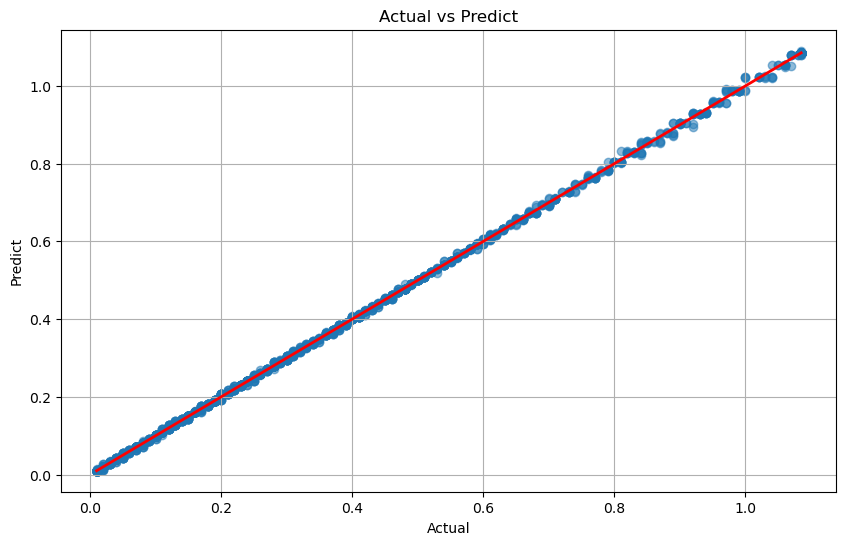

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title("Actual vs Predict")
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.grid()
plt.show()

In [38]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# 결정 트리 모델 초기화
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)

# 모델 학습
tree_model.fit(X_train, y_train)

# 예측
y_pred_tree = tree_model.predict(X_test)

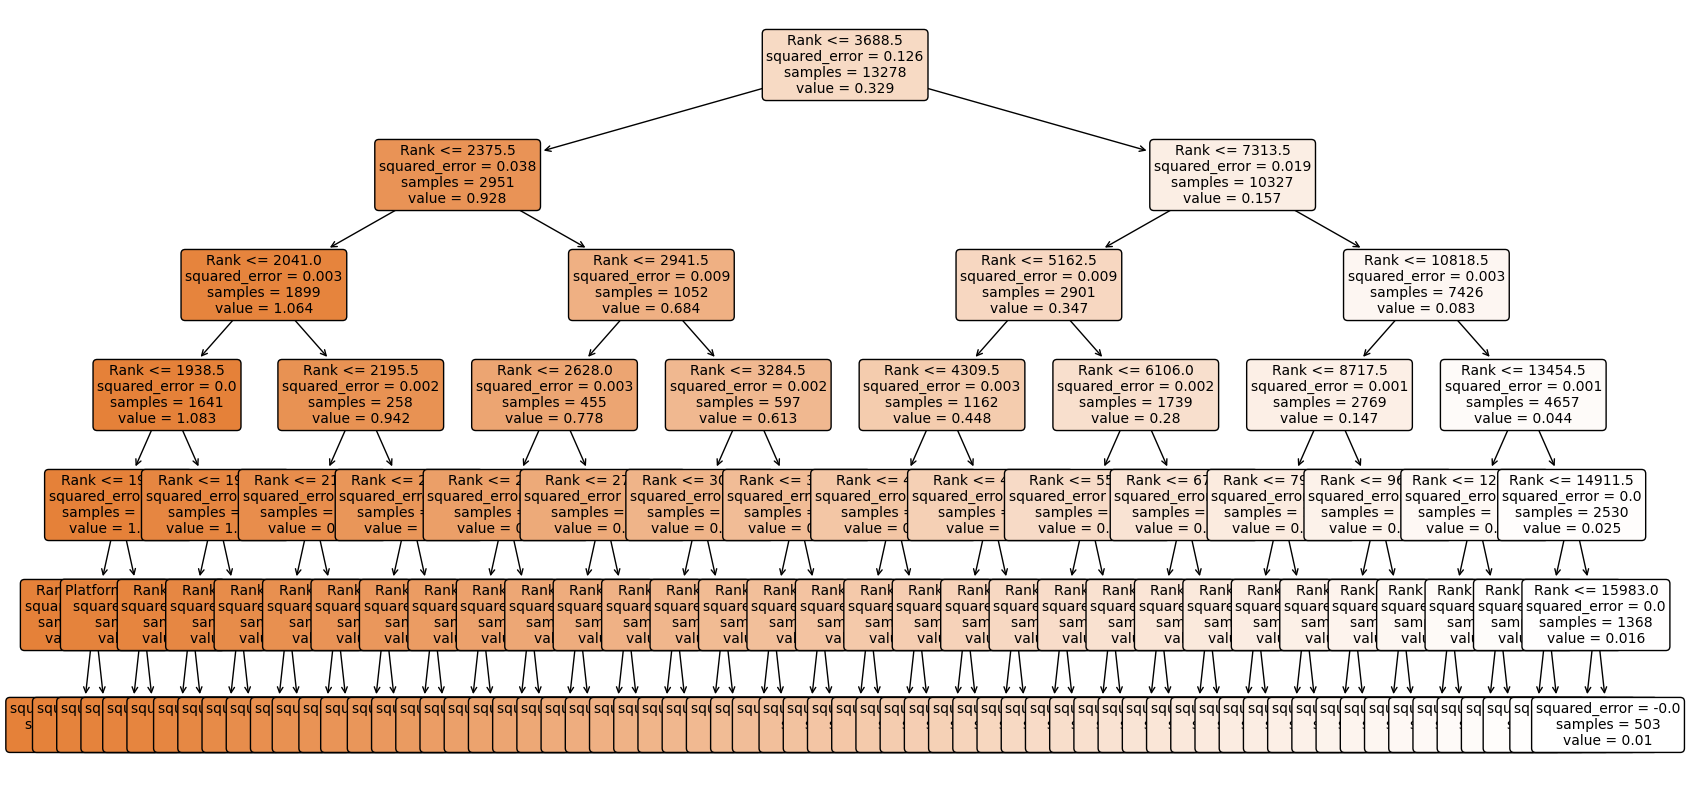

In [39]:
# 결정 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model, 
    feature_names=X.columns,  # 특성 이름
    filled=True,              # 색상 추가
    rounded=True,             # 박스를 둥글게
    fontsize=10               # 글꼴 크기
)
plt.show()

# chat GPT를 사용한 부분
https://chatgpt.com/share/67583189-fe50-8013-a11b-fbb6ae86222b